In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [0]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

In [0]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
# !unzip UCI\ HAR\ Dataset.zip

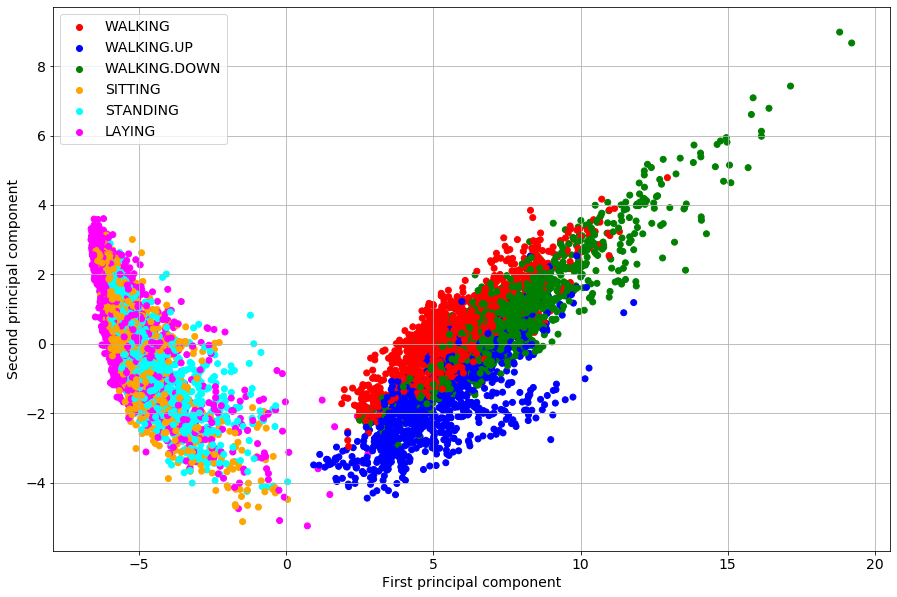

In [4]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

In [5]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [6]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [0]:
import torch

In [0]:
cuda = torch.device('cuda')

In [9]:
X_train.shape

(7352, 128, 9)

In [0]:
x = X_train[0]

In [0]:
x_tr = x[:32].reshape(9, 32)
y = x[32:64].reshape(9, 32)

In [0]:
x_tr = torch.from_numpy(x_tr)
y = torch.from_numpy(y)

In [0]:
model = torch.nn.Linear(32, 32)
loss_function = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-2)

In [14]:
for i in range(1000):
    opt.zero_grad()
    y_pred = model(x_tr)
    loss = loss_function(y, y_pred)
    loss.backward()
    opt.step()
    if not i % 50:
        print(loss)

tensor(0.1640, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(2.8783e-06, grad_fn=<MeanBackward0>)
tensor(1.4703e-08, grad_fn=<MeanBackward0>)
tensor(8.3560e-11, grad_fn=<MeanBackward0>)
tensor(3.8517e-09, grad_fn=<MeanBackward0>)
tensor(2.5931e-12, grad_fn=<MeanBackward0>)
tensor(7.0845e-13, grad_fn=<MeanBackward0>)
tensor(5.8631e-10, grad_fn=<MeanBackward0>)
tensor(1.4530e-08, grad_fn=<MeanBackward0>)
tensor(4.7368e-11, grad_fn=<MeanBackward0>)
tensor(1.7029e-08, grad_fn=<MeanBackward0>)
tensor(2.0226e-12, grad_fn=<MeanBackward0>)
tensor(1.2313e-14, grad_fn=<MeanBackward0>)
tensor(2.9219e-08, grad_fn=<MeanBackward0>)
tensor(5.3837e-10, grad_fn=<MeanBackward0>)
tensor(5.0268e-08, grad_fn=<MeanBackward0>)
tensor(1.3603e-07, grad_fn=<MeanBackward0>)
tensor(1.3638e-08, grad_fn=<MeanBackward0>)
tensor(1.8535e-08, grad_fn=<MeanBackward0>)


In [0]:
z1 = [float(n) for n in y_pred[:][0]]
z2 = [float(n) for n in y[:][0]]

In [0]:
time_series = pd.DataFrame({'y_pred': z1, 'y': z2})

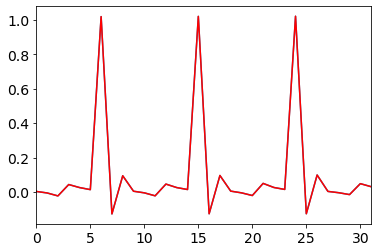

In [17]:
# Строим отдельный ряд из многомерного ряда и смотрим как модель подстроилась
plt.figure()
time_series.y.plot()
time_series.y_pred.plot(color='r')
pylab.show()

In [0]:
x_test = x[64:96].reshape(9, 32)
y = x[96:128].reshape(9, 32)
x_test = torch.from_numpy(x_test)
y = torch.from_numpy(y)

In [0]:
y_pred = model(x_test)

In [0]:
z1 = [float(n) for n in y_pred[:][0]]
z2 = [float(n) for n in y[:][0]]
time_series = pd.DataFrame({'y_pred1': z1, 'y_test1': z2})

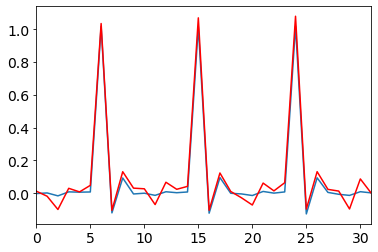

In [21]:
plt.figure()
time_series.y_test1.plot()
time_series.y_pred1.plot(color='r')
pylab.show()

In [0]:
#x = X_train[5000]

In [0]:
#x_tr = x[:128].reshape(9, 128)
#y = x[100:128].reshape(9, 28)

In [0]:
#x_tr = torch.from_numpy(x_tr)
#y = torch.from_numpy(y)

In [0]:
#y_pred = model(x_tr)

In [0]:
#z1 = [float(n) for n in y_pred[:][0]]
#z2 = [float(n) for n in y[:][0]]

In [0]:
#time_series = pd.DataFrame({'y_pred1': z1, 'y1': z2})

In [0]:
#plt.figure()
#time_series.y1.plot()
#time_series.y_pred1.plot(color='r')
#pylab.show()

In [29]:
model.weight

Parameter containing:
tensor([[ 0.0043, -0.0403,  0.0944,  ..., -0.0189, -0.0539, -0.0624],
        [ 0.0598,  0.3472,  0.0005,  ..., -0.0491,  0.1168,  0.0375],
        [-0.0836, -0.0447,  0.2821,  ...,  0.2960, -0.0615, -0.0425],
        ...,
        [ 0.0358, -0.1101,  0.2101,  ...,  0.1430, -0.0552, -0.0978],
        [ 0.0150,  0.0890, -0.1256,  ...,  0.0271,  0.1364,  0.0190],
        [ 0.1275, -0.1650, -0.0400,  ..., -0.0699,  0.0766,  0.3259]],
       requires_grad=True)

In [30]:
%%time
X_train_new = []
for x in X_train:
    x_tr = x[:32].reshape(9, 32)
    y = x[32:64].reshape(9, 32)
    x_tr = torch.from_numpy(x_tr)
    y = torch.from_numpy(y)
    model = torch.nn.Linear(32, 32)
    loss_function = torch.nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-2)
    for i in range(1000):
        opt.zero_grad()
        y_pred = model(x_tr)
        loss = loss_function(y, y_pred)
        loss.backward()
        opt.step()
    X_train_new.append(model.weight)

CPU times: user 59min 5s, sys: 4min 10s, total: 1h 3min 15s
Wall time: 1h 2min 54s


In [32]:
%%time
X_test_new = []
for x in X_test:
    x_tr = x[:32].reshape(9, 32)
    y = x[32:64].reshape(9, 32)
    x_tr = torch.from_numpy(x_tr)
    y = torch.from_numpy(y)
    model = torch.nn.Linear(32, 32)
    loss_function = torch.nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-2)
    for i in range(1000):
        opt.zero_grad()
        y_pred = model(x_tr)
        loss = loss_function(y, y_pred)
        loss.backward()
        opt.step()
    X_test_new.append(model.weight)

CPU times: user 24min 40s, sys: 1min 50s, total: 26min 30s
Wall time: 26min 24s


In [0]:
X_train_new = np.array(X_train_new)
X_test_new = np.array(X_test_new)

In [0]:
for i in range(len(X_train_new)):
    X_train_new[i] = X_train_new[i].detach().numpy()

In [0]:
for i in range(len(X_test_new)):
    X_test_new[i] = X_test_new[i].detach().numpy()

In [36]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, LeakyReLU

Using TensorFlow backend.


In [0]:
from keras.utils import to_categorical
from keras.utils import np_utils

In [0]:
X_train_new = np.array(X_train_new.tolist())

In [0]:
X_test_new = np.array(X_test_new.tolist())

In [0]:
X_train_new = X_train_new.reshape(X_train_new.shape[0], 1, 32 ,32)
X_train_new = X_train_new.astype('float32')
X_train_new /= np.amax(X_train_new)
y_train_new = y_train.reshape(-1)
Y_train_new = np_utils.to_categorical(y_train, 6)

In [41]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,32,32), data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Convolution2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) 
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.9)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [42]:
model.fit(X_train_new, Y_train_new, epochs=200, validation_split=0.1, batch_size=16,shuffle=True, callbacks=[reduce_lr])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6616 samples, validate on 736 samples
Epoch 1/200
6616/6616 [==============================] - 3s 481us/step - loss: 1.2962 - acc: 0.3594 - val_loss: 1.0040 - val_acc: 0.4932
Epoch 2/200
6616/6616 [==============================] - 2s 322us/step - loss: 1.0598 - acc: 0.4732 - val_loss: 0.9608 - val_acc: 0.4688
Epoch 3/200
6616/6616 [==============================] - 2s 322us/step - loss: 1.0161 - acc: 0.5036 - val_loss: 0.8940 - val_acc: 0.6019
Epoch 4/200
6616/6616 [==============================] - 2s 319us/step - loss: 0.9960 - acc: 0.5215 - val_loss: 0.8565 - val_acc: 0.6793
Epoch 5/200
6616/6616 [==============================] - 2s 317us/step - loss: 0.9831 - acc: 0.5322 - val_loss: 0.8470 - val_acc: 0.6168
Epoch 6/200
6616/6616 [==============================] - 2s 322us/step - loss: 0.9671 - acc: 0.5511 - val_loss: 0.8320 - val_acc: 0.6399
Epoch 7/200
6616/6616 [============

In [43]:
X_test_new = X_test_new.reshape(X_test_new.shape[0], 1, 32, 32)
X_test_new = X_test_new.astype('float32')
X_test_new /= np.amax(X_test_new)
predictions= model.predict(X_test_new)
y_pred = [np.argmax(x) for x in predictions]
y_test = y_test.reshape(-1)
(y_pred == y_test).mean()

0.4706481167288768